Notes on tutorial: <https://pytorch.org/rl/stable/tutorials/multiagent_ppo.html>

In [1]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

import torchrl

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Devices
device = 'cpu'
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 60  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

In [3]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 12

from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel

channel = EngineConfigurationChannel()

base_env = torchrl.envs.UnityMLAgentsEnv(
    registered_name="3DBall",
    device=device,
    side_channels=[channel],
)

# Set the Unity time scale to a large number to make it run faster.
channel.set_configuration_parameters(time_scale = 10.0)

t = torchrl.envs.Stack(
    in_keys=[('group_0', f'agent_{idx}') for idx in range(12)],
    out_key='agents',
    in_key_inv='agents',
    out_keys_inv=[('group_0', f'agent_{idx}') for idx in range(12)],
)
env = torchrl.envs.TransformedEnv(base_env, t)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [4]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: Composite(
    agents: Composite(
        continuous_action: BoundedContinuous(
            shape=torch.Size([12, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([12])),
    device=cpu,
    shape=torch.Size([]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([12, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            do

In [5]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'continuous_action')]
reward_keys: [('agents', 'group_reward'), ('agents', 'reward')]
done_keys: [('agents', 'done'), ('agents', 'terminated'), ('agents', 'truncated')]


In [6]:
reward_key = ('agents', 'reward')

env = TransformedEnv(
    env,
    RewardSum(
        in_keys=[reward_key],
        out_keys=[("agents", "episode_reward")]
    ),
)

In [7]:
check_env_specs(env)

2025-02-14 11:51:31,276 [torchrl][INFO] check_env_specs succeeded!


In [8]:
n_rollout_steps = 6
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([6, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([6, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([6, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([6, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([6, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([6, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([6, 12]),
            device=cpu,
            is_shared=False),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    f

In [9]:
print(env.action_spec)

BoundedContinuous(
    shape=torch.Size([12, 2]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)


/home/endoplasm/develop/torchrl-mlagents/torchrl/envs/common.py:1105: DeprecationWarning: You are querying a non-trivial, single action_spec, i.e., there is only one action known by the environment but it is not named `'action'`. Currently, env.action_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(


In [10]:
share_parameters_policy = True

observation_key = ("agents", "VectorSensor_size8")

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec[observation_key].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

In [11]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[observation_key],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [12]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)  # we'll need the log-prob for the PPO loss

In [13]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec[observation_key].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[observation_key],
    out_keys=[("agents", "state_value")],
)

In [14]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                loc: Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                sample_log_prob: Tensor(shape=torch.Size([12]), device=cpu, dtype=torch.float32, is_shared=False),
                scale: Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
         

In [15]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [16]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [17]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    #reward=env.reward_key,
    reward=reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [18]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 0:   0%|          | 0/60 [00:00<?, ?it/s]/home/endoplasm/develop/torchrl-mlagents/torchrl/envs/libs/unity_mlagents.py:381: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(
episode_reward_mean = 0.10000000149011612: 100%|██████████| 60/60 [1:17:43<00:00, 73.95s/it]

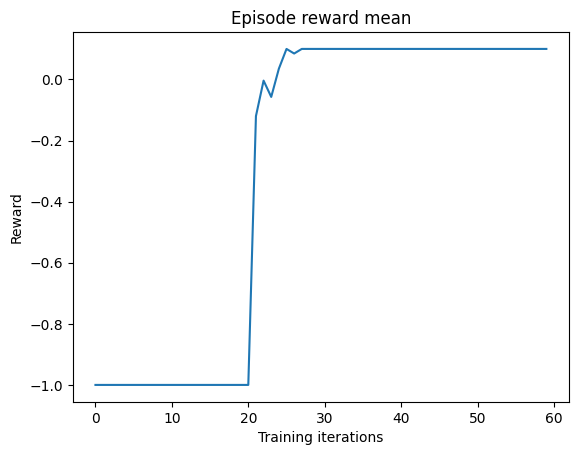

In [19]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [42]:
torch.save(policy, '3DBall-PPO-2.pt')

In [10]:
policy_loaded = torch.load('3DBall-PPO-2.pt')

/tmp/ipykernel_603697/2506938541.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_loaded = torch.load('3DBall-PPO-2.pt')


In [8]:
base_env.close()

Let's run the model in graphical mode without training to make sure it works.

In [13]:
base_env = torchrl.envs.UnityMLAgentsEnv(
    registered_name="3DBall",
    device=device,
)

t = torchrl.envs.Stack(
    in_keys=[('group_0', f'agent_{idx}') for idx in range(12)],
    out_key='agents',
    in_key_inv='agents',
    out_keys_inv=[('group_0', f'agent_{idx}') for idx in range(12)],
)
env = TransformedEnv(
    base_env,
    t,
)

with torch.no_grad():
   env.rollout(
       max_steps=2*max_steps,
       policy=policy_loaded,
       auto_cast_to_device=True,
       break_when_any_done=False,
       break_when_all_done=False,
   )

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [14]:
base_env.close()